# Data Preparation

In [ ]:
from os import listdir
from os.path import join

from torch.utils.data import Dataset
import torchvision.transforms as transforms
from PIL import Image, ImageFilter

def is_image_file(filename):
    return any(filename.endswith(extension) for extension in [".png", ".jpg", ".jpeg"])

def load_img(filepath):
    img = Image.open(filepath).convert('YCbCr')
    y, _, _ = img.split()
    return y

CROP_SIZE = 32

class DatasetFromFolder(Dataset):
    def __init__(self, image_dir, zoom_factor):
        super(DatasetFromFolder, self).__init__()
        self.image_filenames = [join(image_dir, x) for x in listdir(image_dir) if is_image_file(x)]

        crop_size = CROP_SIZE - (CROP_SIZE % zoom_factor) # Valid crop size
        self.input_transform = transforms.Compose([transforms.CenterCrop(crop_size), # cropping the image
                                      transforms.Resize(crop_size//zoom_factor),  # subsampling the image (half size)
                                      transforms.Resize(crop_size, interpolation=Image.BICUBIC),  # bicubic upsampling to get back the original size 
                                      transforms.ToTensor()])
        self.target_transform = transforms.Compose([transforms.CenterCrop(crop_size), # since it's the target, we keep its original quality
                                       transforms.ToTensor()])

    def __getitem__(self, index):
        input = load_img(self.image_filenames[index])
        target = input.copy()
        
        # input = input.filter(ImageFilter.GaussianBlur(1)) 
        input = self.input_transform(input)
        target = self.target_transform(target)

        return input, target

    def __len__(self):
        return len(self.image_filenames)


# Model Building

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=0)
        self.conv3 = nn.Conv2d(32, 1, kernel_size=5, padding=2)
        
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = self.conv3(out)

        return out

# model Training

In [ ]:
import argparse
from math import log10
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [ ]:
zoom_factor=2
nb_epochs=200

# device = torch.device("cuda:0" if (torch.cuda.is_available()  else "cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(0)
torch.cuda.manual_seed(0)

# Parameters
BATCH_SIZE = 4
NUM_WORKERS = 0 # on Windows, set this variable to 0

trainset = DatasetFromFolder("data/train", zoom_factor=zoom_factor)
testset = DatasetFromFolder("data/test", zoom_factor=zoom_factor)

trainloader = DataLoader(dataset=trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
testloader = DataLoader(dataset=testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

model = SRCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(  # we use Adam instead of SGD like in the paper, because it's faster
    [
        {"params": model.conv1.parameters(), "lr": 0.0001},  
        {"params": model.conv2.parameters(), "lr": 0.0001},
        {"params": model.conv3.parameters(), "lr": 0.00001},
    ], lr=0.00001,
)

for epoch in range(nb_epochs):

    # Train
    epoch_loss = 0
    for iteration, batch in enumerate(trainloader):
        input, target = batch[0].to(device), batch[1].to(device)
        optimizer.zero_grad()

        out = model(input)
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch}. Training loss: {epoch_loss / len(trainloader)}")

    # Test
    avg_psnr = 0
    with torch.no_grad():
        for batch in testloader:
            input, target = batch[0].to(device), batch[1].to(device)

            out = model(input)
            loss = criterion(out, target)
            psnr = 10 * log10(1 / loss.item())
            avg_psnr += psnr
    print(f"Average PSNR: {avg_psnr / len(testloader)} dB.")
    model_dir = "models/"
    # Save model
    torch.save(model, os.path.join(model_dir, 'epoch-{}.pth'.format(epoch)))

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


Epoch 0. Training loss: 0.21571256019293317
Average PSNR: 9.346408873973004 dB.
Epoch 1. Training loss: 0.05638898057597024
Average PSNR: 15.847331252405622 dB.
Epoch 2. Training loss: 0.024405655362421556
Average PSNR: 16.2241600263671 dB.
Epoch 3. Training loss: 0.022050070724198744
Average PSNR: 16.69354496407588 dB.
Epoch 4. Training loss: 0.019558036433798925
Average PSNR: 17.2875794005501 dB.
Epoch 5. Training loss: 0.016525781181241785
Average PSNR: 17.9985082191307 dB.
Epoch 6. Training loss: 0.01393943890515301
Average PSNR: 18.676192177300596 dB.
Epoch 7. Training loss: 0.01186710704738895
Average PSNR: 19.373884456351277 dB.
Epoch 8. Training loss: 0.010206114500761032
Average PSNR: 19.97102303792336 dB.
Epoch 9. Training loss: 0.008938665571992122
Average PSNR: 20.45902612387798 dB.
Epoch 10. Training loss: 0.008007937835322486
Average PSNR: 20.899480125151 dB.
Epoch 11. Training loss: 0.007227703200889722
Average PSNR: 21.325131485010573 dB.
Epoch 12. Training loss: 0.0065

In [ ]:
import argparse

import numpy as np
import torch
import torchvision.transforms as transforms
from PIL import Image

model="models/epoch-199.pth"
image="3.png"
zoom_factor=2

img = Image.open(image).convert('YCbCr')
img = img.resize((int(img.size[0]*zoom_factor), int(img.size[1]*zoom_factor)), Image.BICUBIC)  # first, we upscale the image via bicubic interpolation
y, cb, cr = img.split()

img_to_tensor = transforms.ToTensor()
input = img_to_tensor(y).view(1, -1, y.size[1], y.size[0])  # we only work with the "Y" channel

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = torch.load(model).to(device)
input = input.to(device)

out = model(input)
out = out.cpu()
out_img_y = out[0].detach().numpy()
out_img_y *= 255.0
out_img_y = out_img_y.clip(0, 255)
out_img_y = Image.fromarray(np.uint8(out_img_y[0]), mode='L')

out_img = Image.merge('YCbCr', [out_img_y, cb, cr]).convert('RGB')  # we merge the output of our network with the upscaled Cb and Cr from before
                                                                    # before converting the result in RGB
out_img.save(f"zoomed_{image}")


cpu


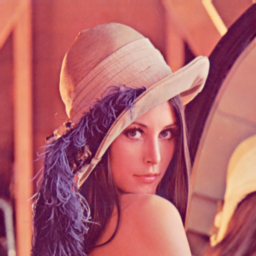

In [ ]:
Image.open("3.png")

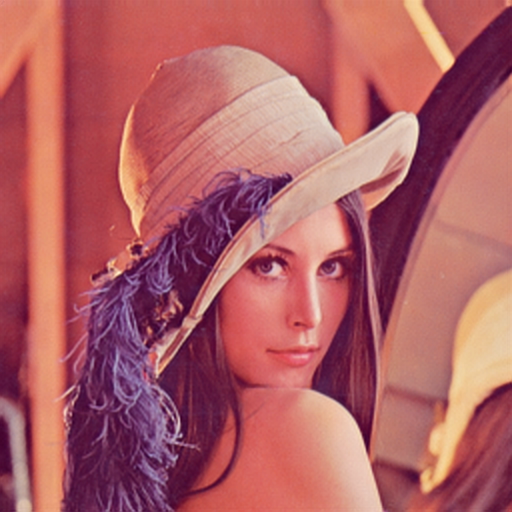

In [ ]:
Image.open("zoomed_3.png")